<a href="https://colab.research.google.com/github/AlvaroJustus/COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import plotly.express as px
import folium

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

## Preprocessing & Derive Tables

In [0]:
keys = confirmed_df.keys()
confirmed = confirmed_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
deaths = deaths_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
recoveries = recoveries_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)

In [0]:
dates = keys.drop(['Province/State', 'Country/Region', 'Lat', 'Long'])

In [0]:
deaths_rates = pd.DataFrame(deaths.sum()/confirmed.sum())
deaths_rates.rename(columns={0:'Mortality Rate'},inplace=True)
recoveries_rates = pd.DataFrame(recoveries.sum()/confirmed.sum())
recoveries_rates.rename(columns={0:'Recovery Rate'},inplace=True)

In [0]:
world_cases = confirmed.sum()
world_deaths = deaths.sum()
world_recoveries = recoveries.sum()
days_1_22 = pd.DataFrame(np.array([i for i in range(len(confirmed.keys()))]).reshape(-1, 1))
br_cases = confirmed[confirmed_df['Country/Region'] == 'Brazil']
it_cases = confirmed[confirmed_df['Country/Region'] == 'Italy']
ch_cases = confirmed[confirmed_df['Country/Region'] == 'China']
us_cases = confirmed[confirmed_df['Country/Region'] == 'US']
sa_cases = confirmed[confirmed_df['Country/Region'] == 'South Africa']
es_cases = confirmed[confirmed_df['Country/Region'] == 'Spain']

In [0]:
LatLong = pd.DataFrame((confirmed_df.groupby(['Country/Region']).sum()).iloc[:,0:2]).reset_index()
latest_confirmed = pd.DataFrame((confirmed_df.groupby(['Country/Region']).sum()).iloc[:,-1]).reset_index()
latest_confirmed.rename(columns= {"Country/Region":"Country/Region","3/28/20": "Confirmed"},inplace=True)
latest_recoveries = pd.DataFrame((recoveries_df.groupby(['Country/Region']).sum()).iloc[:,-1]).reset_index()
latest_recoveries.rename(columns= {"Country/Region":"Country/Region","3/28/20": "Recovered"},inplace=True)
latest_deaths = pd.DataFrame((deaths_df.groupby(['Country/Region']).sum()).iloc[:,-1]).reset_index()
latest_deaths.rename(columns= {"Country/Region":"Country/Region","3/28/20": "Deaths"},inplace=True)

In [0]:
By_Countries = pd.concat([latest_confirmed,latest_recoveries,latest_deaths], axis=1)
By_Countries2 = pd.concat([LatLong,latest_confirmed,latest_recoveries,latest_deaths], axis=1)
By_Countries = By_Countries.loc[:,~By_Countries.columns.duplicated()]
By_Countries['Active'] = By_Countries['Confirmed'] - By_Countries['Deaths'] - By_Countries['Recovered']
By_Countries2 = By_Countries2.loc[:,~By_Countries2.columns.duplicated()]
By_Countries2['Active'] = By_Countries['Confirmed'] - By_Countries['Deaths'] - By_Countries['Recovered']
By_Countries2['Mortality Rate'] = (By_Countries['Deaths']/By_Countries['Confirmed'])*100
By_Countries2['Recovery Rate'] = (By_Countries['Recovered']/By_Countries['Confirmed'])*100
By_Countries = By_Countries.sort_values(by='Confirmed', ascending=False)
By_Dates = pd.concat([world_cases, world_recoveries, world_deaths], axis=1).reset_index()
By_Dates.rename(columns= {"index": "Date", 0: "Confirmed", 1: "Recovered",2:"Deaths"}, inplace= True)
By_Dates['Active'] = By_Dates['Confirmed'] - By_Dates['Deaths'] - By_Dates['Recovered']

## Data Visualization & Predict

In [420]:
By_Countries.style.background_gradient(cmap="Blues", subset=['Confirmed'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Oranges", subset=['Active'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])

,Country/Region,Confirmed,Recovered,Deaths,Active
165,US,121478,1072,2026,118380
82,Italy,92472,12384,10023,70065
34,China,81999,75100,3299,3600
150,Spain,73235,12285,5982,54968
63,Germany,57695,8481,433,48781
59,France,38105,5724,2317,30064
78,Iran,35408,11679,2517,21212
169,United Kingdom,17312,151,1021,16140
155,Switzerland,14076,1530,264,12282
117,Netherlands,9819,6,640,9173


In [421]:
map = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(By_Countries2)):
    folium.Circle(
        location=[By_Countries2.iloc[i]['Lat'], By_Countries2.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(By_Countries2.iloc[i]['Country/Region'])+
                    '<li><bold>Confirmed : '+str(By_Countries2.iloc[i]['Confirmed'])+
                    '<li><bold>Active : '+str(By_Countries2.iloc[i]['Active'])+
                    '<li><bold>Recovered : '+str(By_Countries2.iloc[i]['Recovered'])+
                    '<li><bold>Deaths : '+str(By_Countries2.iloc[i]['Deaths']),
        radius=int(By_Countries2.iloc[i]['Confirmed'])**1.1).add_to(map)
map

In [0]:
future_days = 10
future = pd.DataFrame(np.array([i for i in range(len(confirmed.keys())+future_days)]).reshape(-1, 1))
adjusted_dates = pd.DataFrame(future[:-10])

In [0]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [424]:
obj = By_Dates
obj = obj.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Status', value_name='Count')
obj.head()

fig = px.area(obj, x="Date", y="Count", color='Status', height=800,
             title='Cases over time', color_discrete_sequence = ['#21bf73', '#ff2e63', '#fe9801'])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [0]:
MR = By_Countries2[By_Countries2['Confirmed']> 100]
MR = MR.sort_values('Mortality Rate', ascending= True)

In [426]:
fig1 = px.bar(MR.tail(15), x="Mortality Rate", y="Country/Region", text='Mortality Rate', orientation='h')
fig1.update_traces(marker_color='#9F0000', opacity=0.8, textposition='auto')
fig1

In [680]:
fig = px.pie(By_Countries2.sort_values(by='Deaths', ascending= False).reset_index(drop=True).head(15),
       names = "Country/Region",
       values = 'Deaths', height=750,
       title='Number of Deaths Reported',
       color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

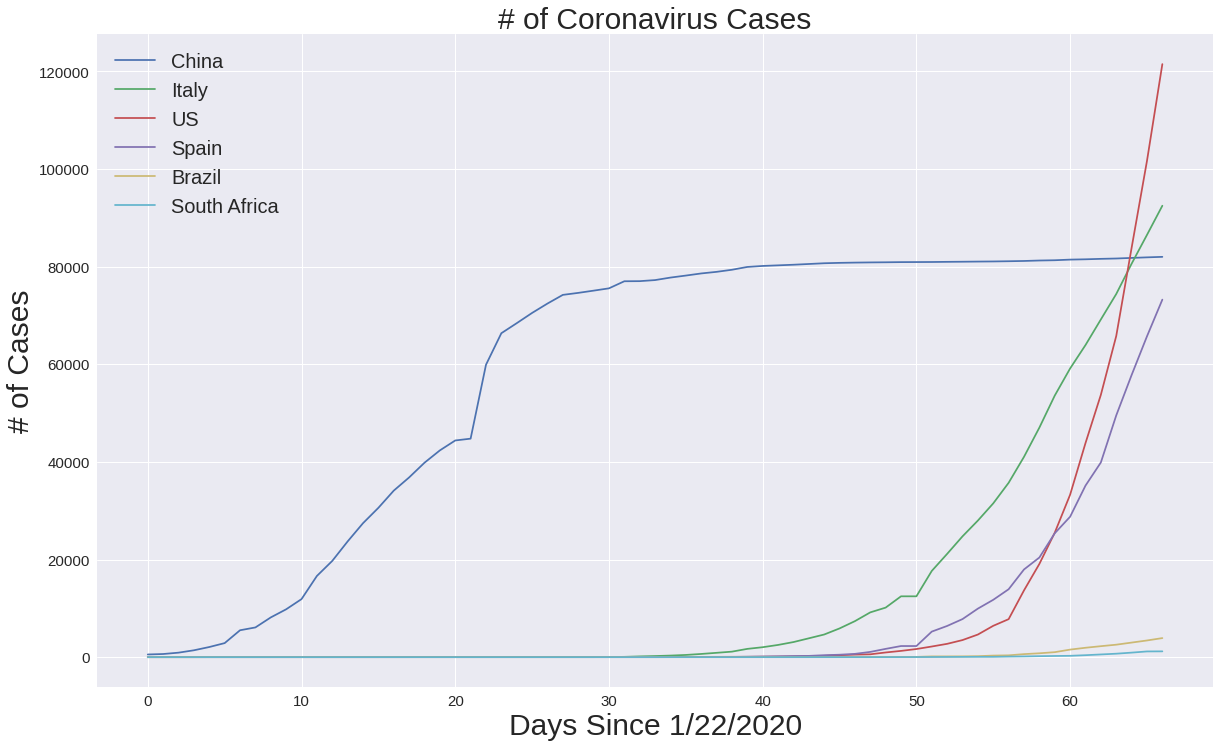

In [679]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, ch_cases.sum())
plt.plot(adjusted_dates, it_cases.sum())
plt.plot(adjusted_dates, us_cases.sum())
plt.plot(adjusted_dates, es_cases.sum())
plt.plot(adjusted_dates, br_cases.sum())
plt.plot(adjusted_dates, sa_cases.sum())
plt.title('Number of Coronavirus Cases', size=30)
plt.xlabel('N Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'Brazil', 'South Africa'], prop={'size': 20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [0]:
from sklearn.model_selection import train_test_split , RandomizedSearchCV
confirmed_X_train, confirmed_X_test, confirmed_y_train, confirmed_y_test = train_test_split(days_1_22, world_cases, test_size=0.18)

### SVR

In [0]:
from sklearn.svm import SVR

In [0]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(confirmed_X_train, confirmed_y_train)
svm_pred = svm_confirmed.predict(future)

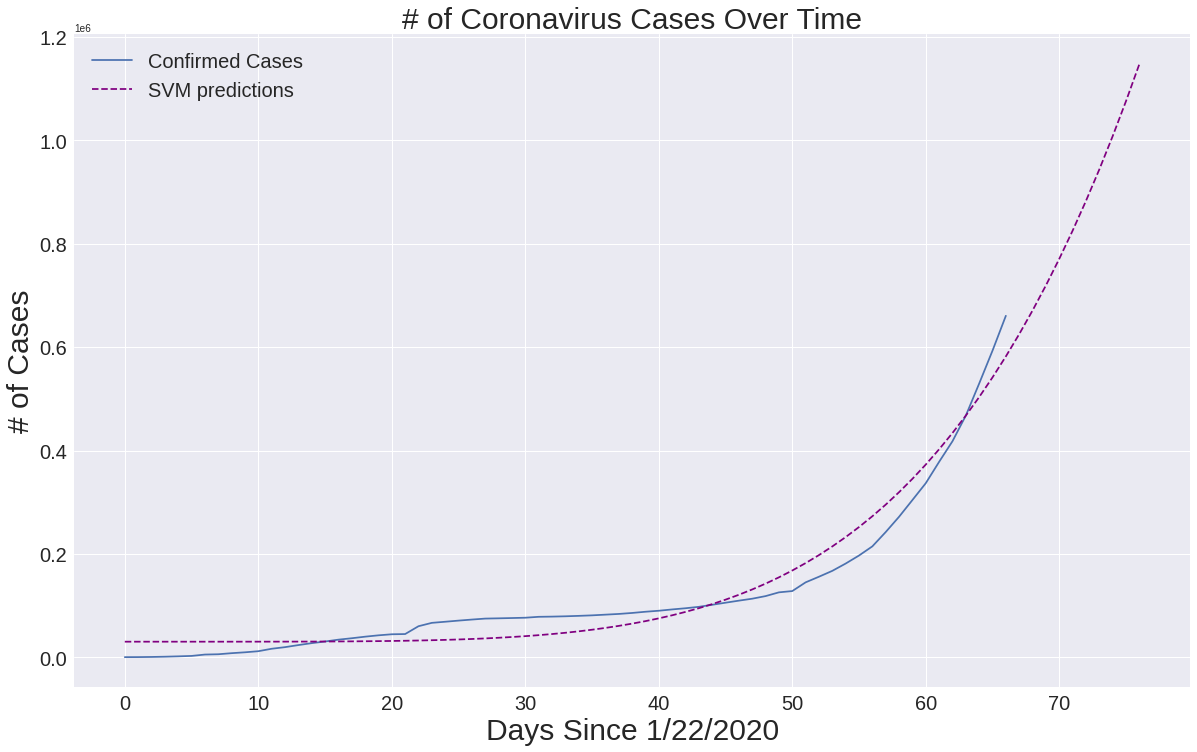

In [684]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future, svm_pred, linestyle='dashed', color='purple')
plt.title('Number of Coronavirus Cases Over Time - SVM', size=30)
plt.xlabel('N Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [685]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('03/29/2020', 625221.0),
 ('03/30/2020', 670951.0),
 ('03/31/2020', 719452.0),
 ('04/01/2020', 770847.0),
 ('04/02/2020', 825264.0),
 ('04/03/2020', 882835.0),
 ('04/04/2020', 943695.0),
 ('04/05/2020', 1007983.0),
 ('04/06/2020', 1075841.0),
 ('04/07/2020', 1147417.0)}

###Polynomial

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(confirmed_X_train)
poly_X_test_confirmed = poly.fit_transform(confirmed_X_test)
poly_future = poly.fit_transform(future)

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, confirmed_y_train)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future)

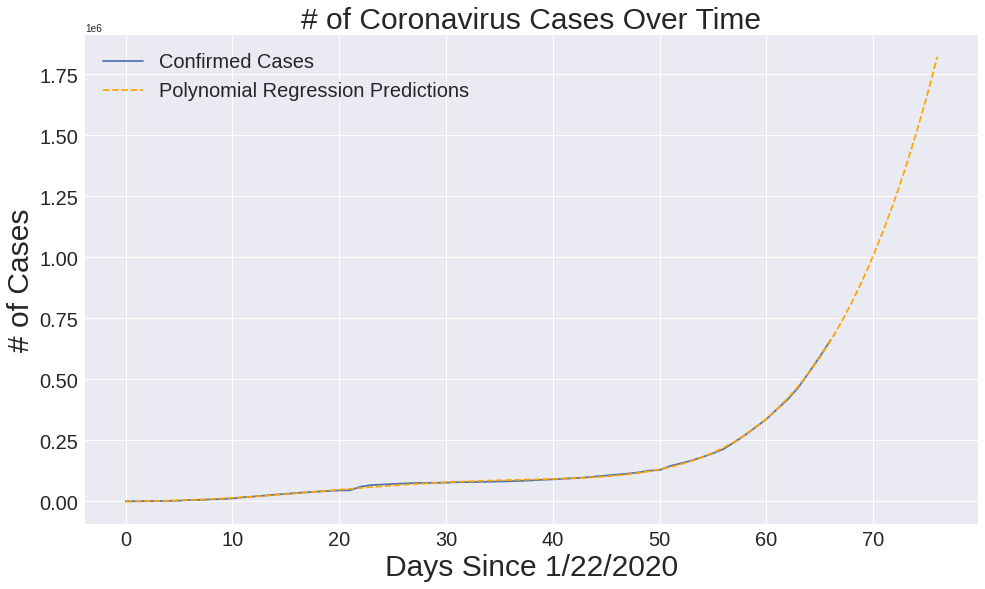

In [689]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future, linear_pred, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Cases Over Time - Polynomial', size=30)
plt.xlabel('N Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [690]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('03/29/2020', 733195.0),
 ('03/30/2020', 816069.0),
 ('03/31/2020', 907080.0),
 ('04/01/2020', 1006789.0),
 ('04/02/2020', 1115782.0),
 ('04/03/2020', 1234668.0),
 ('04/04/2020', 1364080.0),
 ('04/05/2020', 1504679.0),
 ('04/06/2020', 1657148.0),
 ('04/07/2020', 1822199.0)}

### Bayesian Ridge Regression

In [691]:
from sklearn.linear_model import BayesianRidge
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, confirmed_y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [0]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future)

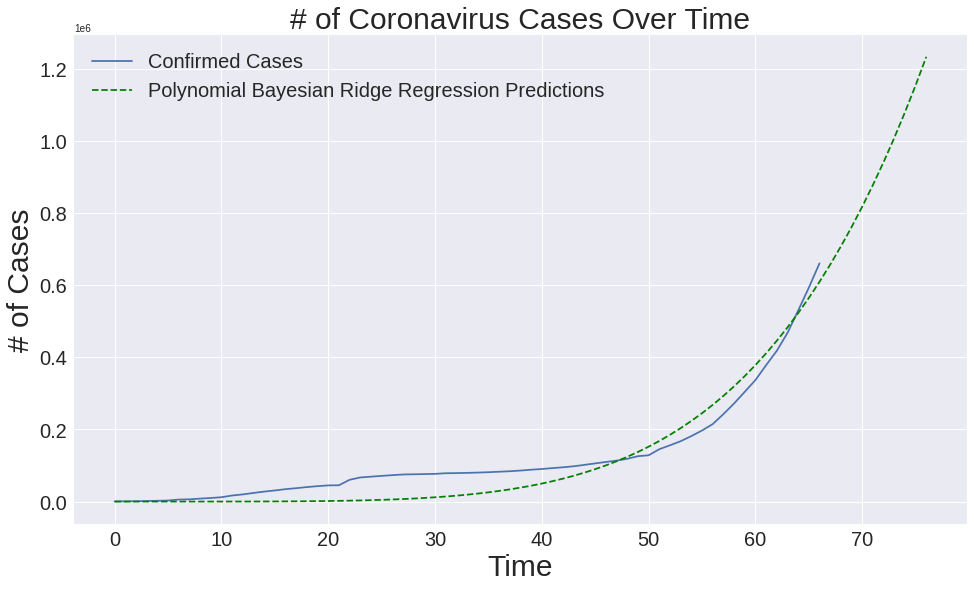

In [693]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [694]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('03/29/2020', 657035.0),
 ('03/30/2020', 707527.0),
 ('03/31/2020', 761077.0),
 ('04/01/2020', 817821.0),
 ('04/02/2020', 877900.0),
 ('04/03/2020', 941460.0),
 ('04/04/2020', 1008648.0),
 ('04/05/2020', 1079619.0),
 ('04/06/2020', 1154530.0),
 ('04/07/2020', 1233543.0)}